In [163]:
!pip install patched_yolo_infer -q

In [161]:
import copy
import cv2
import numpy as np
import matplotlib.pyplot as plt


def draw_boxes(img_orig, boxes_array, conf_threshold):
    """
    Создаёт копию исходного изображения и рисует все боксы из списка,
    фильтруя по порогу confidence. Автоматические боксы рисуются зелёным,
    вручную добавленные (confidence=1.0) — красным.

    :param img_orig: np.ndarray, исходное изображение (BGR)
    :param boxes_array: np.ndarray, массив с боксами и confidence, shape (N, 5),
                        каждый ряд: (x1, y1, x2, y2, confidence)
    :param conf_threshold: float, минимальный порог confidence для отображения боксов
    :return: np.ndarray, изображение с нарисованными боксами
    """
    img_copy = copy.deepcopy(img_orig)
    for box in boxes_array:
        x1, y1, x2, y2, conf = box
        if conf < conf_threshold:
            continue
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

        color_auto = (0, 255, 0)      # зелёный для автоматических боксов
        color_manual = (0, 0, 255)    # красный для ручных боксов
        color = color_manual if conf == 1.0 else color_auto

        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 1)
    return img_copy


def show_image(img):
    """
    Отображает изображение с помощью matplotlib (BGR -> RGB).

    :param img: np.ndarray, изображение в формате BGR
    """
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()


def add_box(boxes_array):
    """
    Запрашивает координаты двух точек у пользователя и добавляет новый бокс
    с confidence=1.0 в массив боксов.

    :param boxes_array: np.ndarray, текущий массив боксов с confidence
    :return: np.ndarray, обновлённый массив боксов
    """
    print("Введите координаты 1-й точки через пробел: x1 y1")
    point_1 = input().split()

    print("Введите координаты 2-й точки через пробел: x2 y2")
    point_2 = input().split()

    coordinates = point_1 + point_2

    if len(coordinates) != 4:
        print("Ошибка: у каждой точки должны быть по 2 координаты.")
        return boxes_array

    try:
        x1, y1, x2, y2 = map(int, coordinates)
        new_box = np.array([x1, y1, x2, y2, 1.0])  # confidence=1.0 для ручного бокса
        boxes_array = np.vstack((boxes_array, new_box))
        print("Бокс добавлен.")
    except ValueError:
        print("Ошибка: координаты должны быть числами")

    return boxes_array


def delete_box(boxes_array):
    """
    Позволяет пользователю удалить бокс по индексу.

    :param boxes_array: np.ndarray, текущий массив боксов с confidence
    :return: np.ndarray, обновлённый массив боксов
    """
    if len(boxes_array) == 0:
        print("Список боксов пуст")
        return boxes_array

    print("Список боксов:")
    for i, box in enumerate(boxes_array):
        x1, y1, x2, y2, conf = box
        print(f"{i}: ({int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}) conf={conf:.2f}")

    print("Введите номер бокса для удаления:")
    try:
        idx = int(input())
        if 0 <= idx < len(boxes_array):
            boxes_array = np.delete(boxes_array, idx, axis=0)
            print("Бокс удалён.")
        else:
            print("Неверный индекс.")
    except ValueError:
        print("Ошибка ввода.")

    return boxes_array


def change_conf_threshold(conf_threshold):
    """
    Запрашивает новый порог confidence у пользователя и возвращает его.

    :param conf_threshold: float, текущий порог confidence
    :return: float, обновлённый порог confidence
    """
    print("Введите необходимый порог (от 0 до 1):")
    try:
        new_threshold = float(input())
        if 0 <= new_threshold <= 1.0:
            conf_threshold = new_threshold
            print("Порог изменён.")
        else:
            print("Неверный порог: число должно быть от 0 до 1.")
    except ValueError:
        print("Ошибка ввода: введите число.")

    return conf_threshold


def main_loop(img_orig, boxes_array, conf_threshold):
    """
    Основной интерактивный цикл: отображает боксы, принимает команды пользователя
    для добавления/удаления боксов и изменения порога confidence.

    :param img_orig: np.ndarray, исходное изображение (BGR)
    :param boxes_array: np.ndarray, массив боксов с confidence
    :param conf_threshold: float, порог confidence для фильтрации боксов
    """
    while True:
        img = draw_boxes(img_orig, boxes_array, conf_threshold)
        show_image(img)

        print(f"Количество обнаруженных колоний: {len(boxes_array)}\nПорог confidence: {conf_threshold}")
        print("Выберите действие: 1 - добавить бокс, 2 - удалить бокс, 3 - изменить порог conf, 0 - выйти")
        choice = input()

        if choice == "1":
            boxes_array = add_box(boxes_array)
        elif choice == "2":
            boxes_array = delete_box(boxes_array)
        elif choice == "3":
            conf_threshold = change_conf_threshold(conf_threshold)
        elif choice == "0":
            print("Выход.")
            break
        else:
            print("Неверный ввод.")


def interactive_inference(model, img_path, conf_threshold=0.5):
    """
    Загружает изображение и модель, запускает инференс,
    объединяет боксы с confidence, запускает интерактивный цикл.

    :param model: объект модели YOLO
    :param img_path: str, путь к изображению
    :param conf_threshold: float, начальный порог confidence
    """
    img_orig = cv2.imread(img_path)
    result = model(img_path, verbose=False)
    boxes = result[0].boxes.xyxy.cpu().numpy()
    confs = result[0].boxes.conf.cpu().numpy().reshape(-1, 1)
    combined_result = np.concatenate((boxes, confs), axis=1)

    main_loop(img_orig, combined_result, conf_threshold)


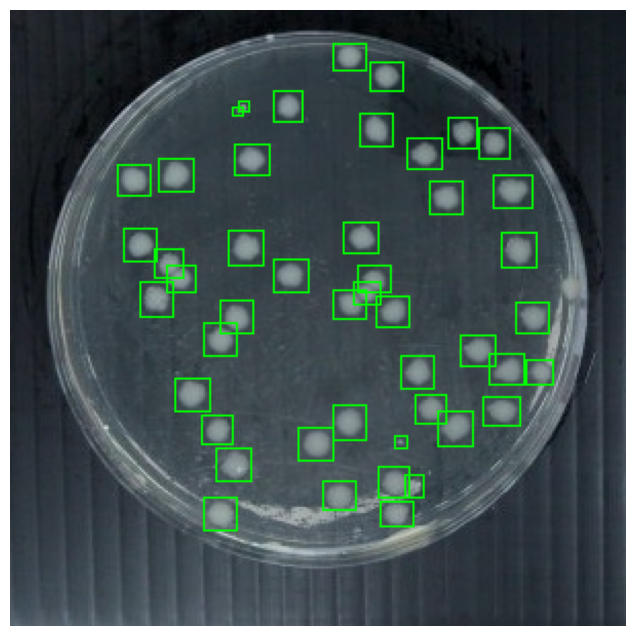

Количество обнаруженных колоний: 54
Порог confidence: 0.5
Выберите действие: 1 - добавить бокс, 2 - удалить бокс, 3 - изменить порог conf, 0 - выйти
Введите необходимый порог (от 0 до 1):
Порог изменён.


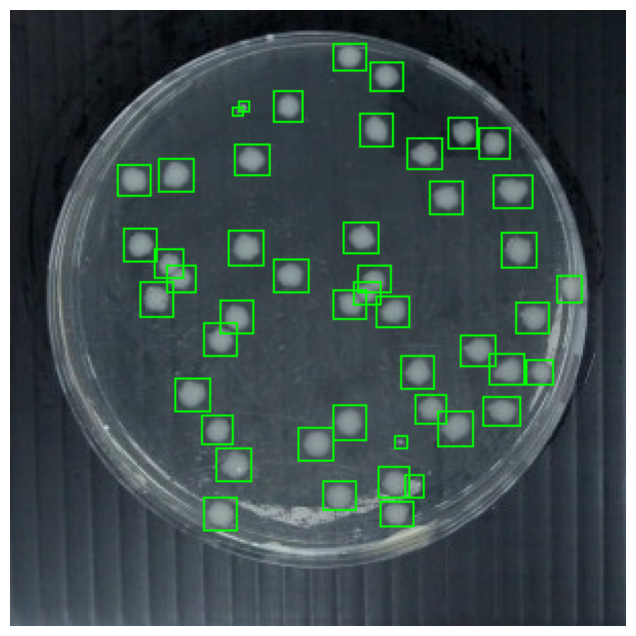

Количество обнаруженных колоний: 54
Порог confidence: 0.4
Выберите действие: 1 - добавить бокс, 2 - удалить бокс, 3 - изменить порог conf, 0 - выйти
Выход.


In [164]:
from ultralytics import YOLO

model = YOLO('runs/detect/train24/weights/best.pt')
img_path = "image(140).jpg"

interactive_inference(
    model = model,
    img_path = img_path)